In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import pandas as pd

In [2]:
# Constants
R = 8.3145
Tc = 304.1  # K
Vc = 93.9 / 100**3  # m^3 mol^-1
Pc = 73.8 * 100000  # pa

### Saturation data for CO2 Found from literature

In [3]:

# specific volumes in m^3/ kg


specific_volume_gas_values = np.array([
    0.01903300, 0.01807400, 0.01719900, 0.01639600, 0.01565600,
    0.01497300, 0.01434000, 0.01375100, 0.01320200, 0.01268800,
    0.01220700, 0.01175500, 0.01132900, 0.01092800, 0.01054800,
    0.01018900, 0.00984760, 0.00952350, 0.00921500, 0.00892080,
    0.00864000, 0.00837150, 0.00811440, 0.00786790, 0.00763120,
    0.00740370, 0.00718470, 0.00697360, 0.00676990, 0.00657310,
    0.00638270, 0.00619820, 0.00601930, 0.00584550, 0.00567650,
    0.00551180, 0.00535120, 0.00519420, 0.00504060, 0.00489000,
    0.00474200, 0.00459620, 0.00445230, 0.00430980, 0.00416820,
    0.00402690, 0.00388510, 0.00374210, 0.00359650, 0.00344640,
    0.00328910, 0.00311950, 0.00292700, 0.00268020, 0.00213860
])


specific_volume_liq_values = np.array([
    0.00097148, 0.00097859, 0.00098567, 0.00099273, 0.00099979,
    0.0010068, 0.0010139, 0.001021, 0.0010281, 0.0010353,
    0.0010425, 0.0010497, 0.001057, 0.0010644, 0.0010718,
    0.0010794, 0.001087, 0.0010947, 0.0011025, 0.0011105,
    0.0011185, 0.0011267, 0.001135, 0.0011436, 0.0011522,
    0.0011611, 0.0011701, 0.0011794, 0.0011889, 0.0011987,
    0.0012087, 0.0012191, 0.0012297, 0.0012408, 0.0012522,
    0.001264, 0.0012763, 0.0012892, 0.0013026, 0.0013167,
    0.0013315, 0.0013472, 0.0013638, 0.0013815, 0.0014006,
    0.0014212, 0.0014438, 0.0014688, 0.0014968, 0.0015289,
    0.0015666, 0.0016131, 0.001675, 0.0017735, 0.0021386
])



# saturation pressure in # MPa
pressure_values = np.array([
    2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
    3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
    4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9,
    5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9,
    6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9,
    7.0, 7.1, 7.2, 7.3, 7.3773
])


envelope_vm_liq = specific_volume_liq_values * 44/1000  * 1000 #Litres
envelope_vm_gas = specific_volume_gas_values * 44/1000 *1000  # Litres
envelope_psat = pressure_values * 10 #bar


### Ideal EOS

In [4]:
# ideal

def fid(T, v):
    global R
    P = (R * T) / v
    return P


### Van Der Waals EOS

In [5]:
#VDW
def fvdw(T, v):
    # Van der Waals constants
    global R, Tc, Pc
    const_a = 27 / 64
    const_b = 1 / 8

    # Van der Waals parameters
    a = const_a * R**2 * Tc**2 / Pc
    b = const_b * R * Tc / Pc

    # Van der Waals equation
    P = R * T / (v - b) - (a / v**2)

    return P


# SRK EOS

In [6]:
#Soave REDLICH KWONG
def fSRK(T, v):
    # SRK constants
    # all parameters are in SI units
    global R, Tc, Pc,Vc

    Tr = T / Tc
    w = 0.239

    # SRK parameters
    A = (1 + (0.48508 + 1.55171 * w - 0.15613 * w**2) * (1 - (Tr)**0.5))**2
    const_a = 1 / (9 * ((2**(1/3)) - 1))
    const_b = (2**(1/3) - 1) / 3
    a = const_a * R**2 * Tc**2 / Pc
    b = const_b * R * Tc / Pc

    # SRK equation
    P = (R * T) / (v - b) - (a * A) / (v * (v + b))

    return P


### Peng Robinson EOS

In [7]:
#Peng Robinson
def fpengr(T, v): # inputs are temps and molar volumes
    # Peng-Robinson constants
    #all parameters are in SI units

    global R,Tc,Pc,Vc  # constants which are recognised in code
    Tr = T / Tc # reduced temperature


    w = 0.238 # acentric factor
    #w = -1 - np.log(P_sat/(Pc/10**5))
    k = 0.37464 + 1.54226 * w - 0.26992 * w**2
    A = (1 + k * (1 - Tr**0.5))**2

    # Peng-Robinson parameters
    const = ((-1 + (6 * np.sqrt(2) + 8)**(1/3)) - (6 * np.sqrt(2) - 8)**(1/3)) / 3
    const_a = 8 * (5 * const + 1) / (49 - 37 * const)
    const_b = const / (const + 3)
    a = A * const_a * R**2 * Tc**2 / Pc
    b = const_b * R * Tc / Pc

    # Peng-Robinson equation
    P = (R * T) / (v - b) - (a) / ((v * (v + b)) + (b * (v - b)))

    return P


### Plotting Peng Robinson

<Figure size 640x480 with 0 Axes>

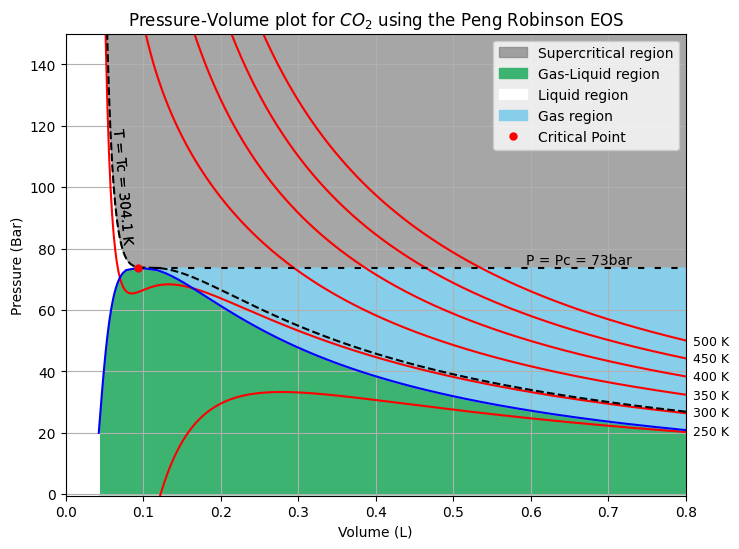

In [8]:
# Peng Robinson Plot
v = np.arange(0.00005, 0.00300, 0.000001) # m^3/mol

# Peng Robinson
T_values_pr = np.linspace(250, 500, 6)
P_pr = np.zeros((len(v), len(T_values_pr)))

#using Peng Robinson function to find pressures for input of molar volumes
for i, vi in enumerate(v):
    P_pr[i, :] = [fpengr(Tj, vi) for Tj in T_values_pr]

P_pr_T = dict(zip(map(lambda T: f"{T} K", T_values_pr), (P_pr / 10**5).tolist()))

# plotting critical isotherm
#plotting
plt.figure()

plt.figure(figsize=(8, 6))

#plotting isotherms
plt.plot(v * 1000, P_pr / 10**5,'r-')

#critical isotherm pressures
#v_critical = np.arange(0.000053, 0.001001, 0.000001)
critical_iso_p = fpengr(Tc,v)

# plotting critical isotherm
plt.plot(v*1000,critical_iso_p/10**5,'k--')

# labeling isotherms
plt.text(0.81, 48.5, f'500 K', fontsize=9, color='black', ha='left')
plt.text(0.81, 43, f'450 K', fontsize=9, color='black', ha='left')
plt.text(0.81, 37, f'400 K', fontsize=9, color='black', ha='left')
plt.text(0.81, 31, f'350 K', fontsize=9, color='black', ha='left')
plt.text(0.81, 25.5, f'300 K', fontsize=9, color='black', ha='left')
plt.text(0.81, 19, f'250 K', fontsize=9, color='black', ha='left')


# labeling critical isotherm
# Add text along the curve
text_to_display = 'T = Tc = 304.1 K'
text_position = (73.9/1000, 100)  # Adjust the position based on your needs

# Create a path effect with stroke
path_effect = withStroke(linewidth=0, foreground='black')

# Add text with the path effect
plt.text(*text_position, text_to_display, path_effects=[path_effect], rotation=-85, ha='center', va='center')




# plotting envelope data
plt.plot(envelope_vm_gas ,envelope_psat,'b-')
plt.plot(envelope_vm_liq,envelope_psat,'b-')

Sc_reg_x = np.arange(Vc,0.001001,0.000001)
Sc_reg_y = np.full_like(Sc_reg_x, Pc)

# adding supercritical bondary
plt.plot(Sc_reg_x*1000,Sc_reg_y/10**5, linestyle=(0, (3, 5)),color = 'black')
plt.text(Sc_reg_x[500]*1000, 75, f'P = Pc = 73bar', fontsize=10, color='black', ha='left')

high_P = fpengr(5000,v)

#shading supercritical region
boundary = np.full_like(v, 73)
#plt.fill_between(v_critical*1000,critical_iso_p, where = critical_iso_p> 73,color='grey', alpha=1)
plt.fill_between(v*1000,P_pr[:,5]/10**5,P_pr[:,4]/10**5,where = P_pr[:,5]/10**5 >73,color='grey', alpha=.7,label='Supercritical region')
plt.fill_between(v*1000,P_pr[:,4]/10**5,P_pr[:,3]/10**5,color='grey', alpha=.7)
plt.fill_between(v*1000,P_pr[:,3]/10**5,P_pr[:,2]/10**5,color='grey', alpha=.7)
plt.fill_between(v*1000,P_pr[:,2]/10**5,critical_iso_p/10**5,color='grey', alpha=.7)
plt.fill_between(v*1000,high_P/10**5,P_pr[:,5]/10**5,color='grey', alpha=.7)



#shading liquid gas region
plt.fill_between(envelope_vm_liq, envelope_psat, color='mediumseagreen', alpha=1,label = 'Gas-Liquid region' )
plt.fill_between(envelope_vm_gas, envelope_psat, color='mediumseagreen', alpha=1)

# #shading liquid region
# too hard to shade another colour, shall keep white :(
liq_b2_y=np.linspace(0,150,len(v))
liq_b2_x = np.full_like(liq_b2_y, 0)
xaxis_vals = np.linspace(0,(42.8/100**3)*1000,len(v))
plt.plot(liq_b2_x,liq_b2_y,'k')
plt.fill_between(xaxis_vals, 0, 150, color='white', alpha=1,label='Liquid region')






#shading gas region
# Shade the region between the gas envelope curve and the horizontal lines
plt.fill_between(envelope_vm_gas,Sc_reg_y[0:len(envelope_psat)]/10**5,envelope_psat,color='skyblue', alpha=1, label='Gas region')

#plotting critical point
plt.plot(Vc * 1000, Pc/10**5, 'r.', markersize=10, linewidth=1,label = 'Critical Point')
#limits on graph
plt.xlim([0, 0.8])
plt.ylim([-0.5, 150])




# plot legends and labels
#plt.legend(list(P_pr_T.keys()))
#plt.legend()
plt.legend()
plt.title('Pressure-Volume plot for $CO_2$ using the Peng Robinson EOS')
plt.xlabel('Volume (L)')
plt.ylabel('Pressure (Bar)')
plt.grid(True)
plt.show()

### EOS Comparison

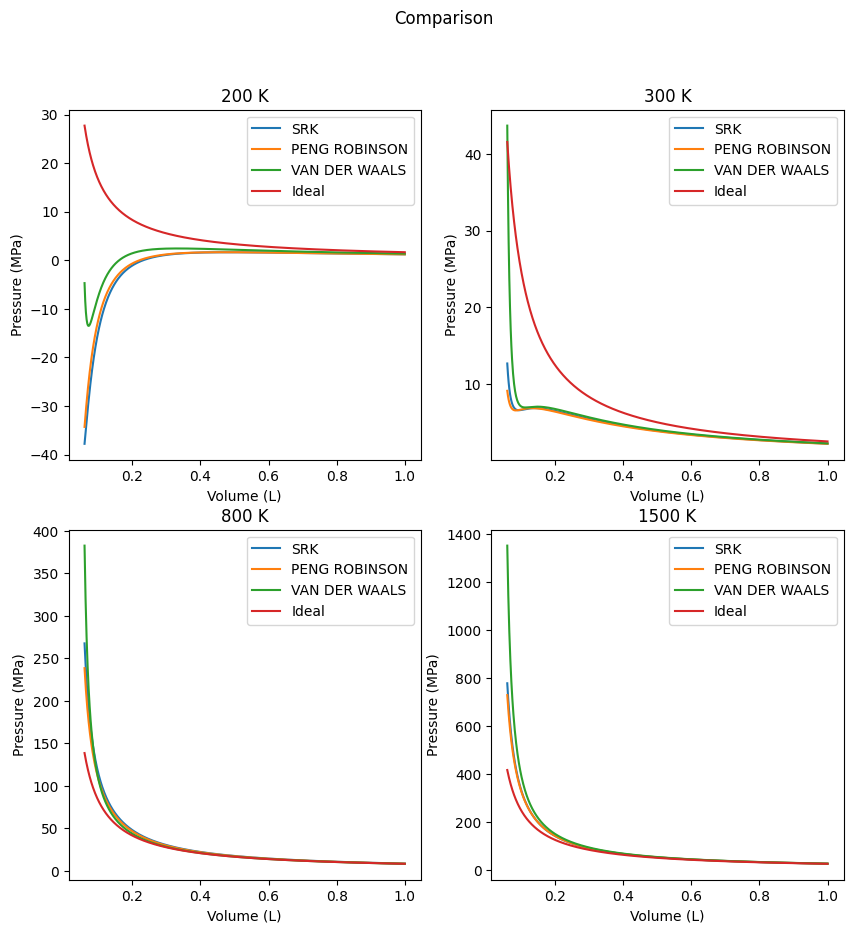

In [9]:

# RUN Q2
# v = np.linspace((1/10000)*0.5, (93.9/100**2), 10000)
v = np.arange(0.00006, 0.001001, 0.000001)
R = 8.314
Tc = 304.1
Pc = 73.8 * 100000
critical_point = [(R * Tc) / (Pc / 10**6) * 10**-3, Pc / 10**5]

# Comparing EOS
T_values = np.array([200, 300, 1000, 3000])
subplot_titles = ['200 K', '300 K', '800 K', '1500 K']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, T in enumerate(T_values):
    P_SRK = fSRK(T, v)
    P_pr = fpengr(T, v)
    P_vdw = fvdw(T, v)
    P_ideal = fid(T, v)

    axs[i // 2, i % 2].plot(v * 1000, P_SRK / 10**6, label='SRK')
    axs[i // 2, i % 2].plot(v * 1000, P_pr / 10**6, label='PENG ROBINSON')
    axs[i // 2, i % 2].plot(v * 1000, P_vdw / 10**6, label='VAN DER WAALS')
    axs[i // 2, i % 2].plot(v * 1000, P_ideal / 10**6, label='Ideal')


    axs[i // 2, i % 2].set_xlabel('Volume (L)')
    axs[i // 2, i % 2].set_ylabel('Pressure (MPa)')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].set_title(subplot_titles[i])


fig.suptitle('Comparison')
plt.show()




### Plotting SRK EOS

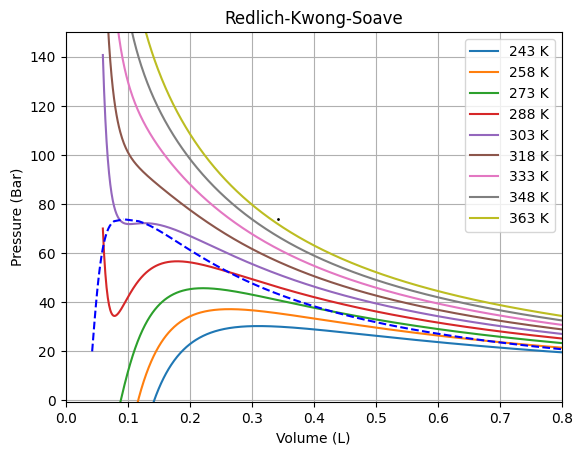

In [10]:
#SRK PLOT

# SRK
# T_values_srk = np.arange(100, 1201, 100)
T_values_srk = np.arange(273 - 30, 273 + 101, 15)
P_SRK = np.zeros((len(v), len(T_values_srk)))

for i, vi in enumerate(v):
    P_SRK[i, :] = [fSRK(Tj, vi) for Tj in T_values_srk]

P_SRK_T = dict(zip(map(lambda T: f"{T} K", T_values_srk), (P_SRK / 10**5).tolist()))

plt.figure()
plt.plot(v * 1000, P_SRK / 10**5)
plt.plot(critical_point[0], critical_point[1], 'k.', markersize=2, linewidth=1)
plt.plot(envelope_vm_gas ,envelope_psat,'b--')
plt.plot(envelope_vm_liq,envelope_psat,'b--')
plt.xlim([0, 0.8])
plt.ylim([-0.5, 150])
plt.legend(list(P_SRK_T.keys()))
plt.title('Redlich-Kwong-Soave')
plt.xlabel('Volume (L)')
plt.ylabel('Pressure (Bar)')
plt.grid(True)
plt.show()

### Plotting Ideal EOS

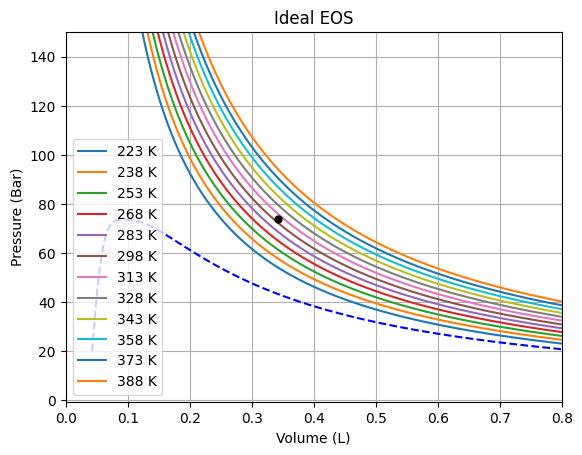

In [11]:
#Ideal Plot
# Ideal
# T_values_ideal = np.arange(100, 1201, 100)
T_values_ideal = np.arange(273 - 50, 273 + 121, 15)
P_id = np.zeros((len(v), len(T_values_ideal)))

for i, vi in enumerate(v):
    P_id[i, :] = [fid(Tj, vi) for Tj in T_values_ideal]

P_id_T = dict(zip(map(lambda T: f"{T} K", T_values_ideal), (P_id / 10**5).tolist()))

plt.figure()
plt.plot(v * 1000, P_id / 10**5)
plt.plot(critical_point[0], critical_point[1], 'k.', markersize=10, linewidth=2)
plt.plot(envelope_vm_gas ,envelope_psat,'b--')
plt.plot(envelope_vm_liq,envelope_psat,'b--')

plt.legend(list(P_id_T.keys()))
plt.title('Ideal EOS')
plt.xlabel('Volume (L)')
plt.ylabel('Pressure (Bar)')
plt.xlim([0, 0.8])
plt.ylim([-0.5, 150])
plt.grid(True)
plt.show()

### Plotting Van der Waals EOS

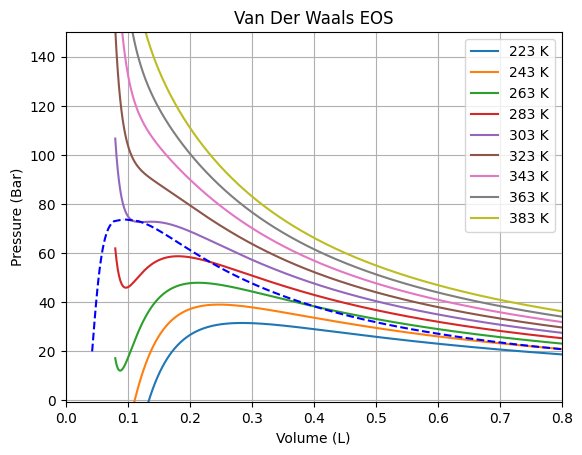

In [12]:

# Define the range for volume (v) and temperature (T)
v = np.arange(0.00008, 0.001001, 0.000001)
T = np.arange(273-50, 273+121, 20)

# Initialize the pressure array
P_vdw = np.zeros((len(v), len(T)))

# Calculate pressure for each combination of v and T
for i in range(len(v)):
    for j in range(len(T)):
        # Assuming fvdw is your van der Waals function
        P_vdw[i, j] = fvdw(T[j], v[i])

# Plot the results
plt.figure()
plt.plot(v * 1000, P_vdw / 1e5)
plt.legend([f'{temp} K' for temp in T])
plt.title('Van Der Waals EOS')
plt.xlabel('Volume (L)')
plt.ylabel('Pressure (Bar)')
plt.ylabel('Pressure (Bar)')
plt.plot(envelope_vm_gas ,envelope_psat,'b--')
plt.plot(envelope_vm_liq,envelope_psat,'b--')
plt.xlim([0, 0.8])
plt.ylim([-0.5, 150])

plt.grid(True)
plt.show()
